In [1]:
'''
References: https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/
'''
import torch
import random
import numpy as np
import selfies as sf
import networkx as nx
import torch_geometric
import group_selfies as gs
import torch.nn.functional as F

from rdkit import Chem
from copy import deepcopy
from dockstring import load_target
from global_chem import GlobalChem
from IPython.display import display
from collections import OrderedDict
from torch_geometric.data import Data
from rdkit.Chem import Descriptors, Draw
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from pathos.multiprocessing import ProcessingPool as Pool
from torch_geometric.utils.convert import to_networkx, from_networkx

/home/raj/anaconda3/envs/rl4chem/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE]

class GroupSelfies_Molecule_Env:
    
    def __init__(self, grammar=None, action_size=100, dockstring_target='DRD2', episode_length=10):
        
        # Creat dockstring target
        self.dockstring_target = load_target(dockstring_target)

        # Create Molecular Action Space
        self.create_molecular_action_space(grammar=grammar, action_size=action_size)
        
        # Set Episode Length
        self.episode_length = episode_length

        self.reset()

    def create_molecular_action_space(self, grammar=None, action_size=100):

        self.grammar = grammar if grammar is not None else gs.group_grammar.common_r_group_replacements_grammar()
        atom_symbols = set([])
        group_selfies_strs = []
        for name, group in self.grammar.vocab.items():
            mol = group.mol_without_attachment_points()
            for a in mol.GetAtoms():
                atom_symbols.add(a.GetSymbol())
            smiles = Chem.MolToSmiles(mol)
            group_selfies_strs.append(self.grammar.full_encoder(Chem.MolFromSmiles(smiles)))

        self.action_space = random.sample(group_selfies_strs, action_size)
        self.atom_symbols = list(atom_symbols)

    def reset(self):
        
        # Initialize Molecule
        self.molecule = None

        # Initialize Step
        self.num_step = 0

    def evaluate_dockstring(self, ligand_smiles):

        score, aux = self.dockstring_target.dock(ligand_smiles)

        return score, aux

    def get_gs_state(self):
        return self.grammar.decoder(self.molecule)
    
    def step(self, action, calc_dockstring=False):
        
        group_sf_string = self.action_space[action]

        if self.molecule is None:
            self.molecule = group_sf_string
        else:
            self.molecule = self.molecule + group_sf_string

        if self.num_step < self.episode_length and calc_dockstring is False:
            self.num_step += 1
            reward = 0; done = False; info = {}
            return self.molecule, reward, done, info
        else:
            mol_smiles = self.grammar.decoder(self.molecule)
            
            '''
            Not calculating docking scores because it takes a lot of time
            '''
            reward = 0
            info = None
            done = True 
            
            #docking_info = self.evaluate_dockstring(ligand_smiles=mol_smiles)
            #reward = docking_info[0]
            #done = True
            #info = {'docking_smiles': mol_smiles, 'docking_group_selfie': self.molecule,
            #        'docking_score': reward, 'docking_affinities': docking_info[1]}
            
            return self.molecule, reward, done, info    

In [3]:
env = GroupSelfies_Molecule_Env()

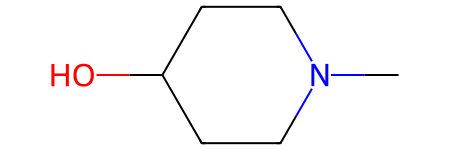

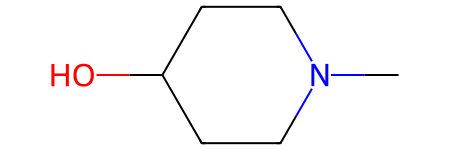

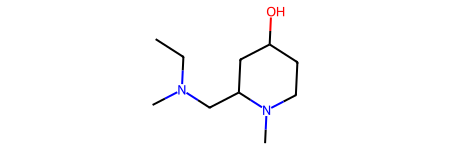

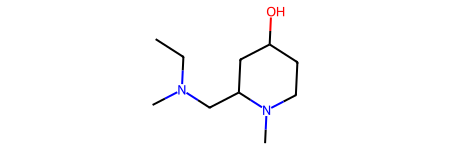

[12:09:23] Incomplete atom labelling, cannot make bond


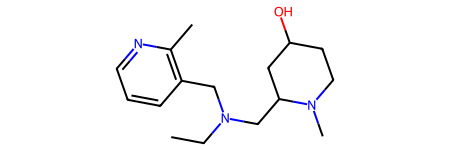

[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond


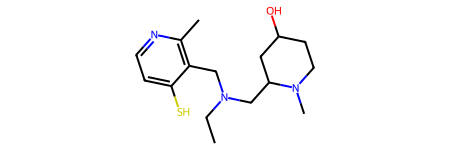

[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond


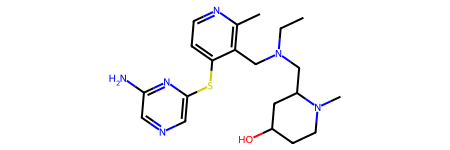

[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond


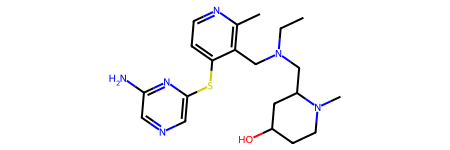

[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond


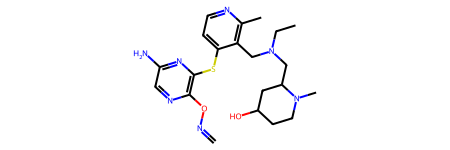

[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond


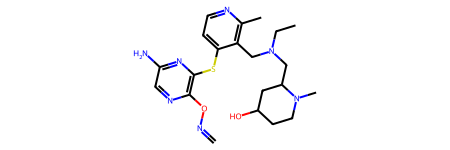

[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond
[12:09:23] Incomplete atom labelling, cannot make bond


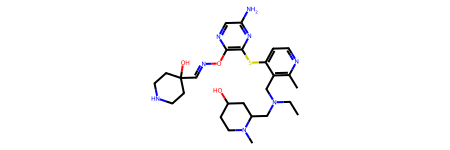

In [4]:
done = False
env.reset()
while not done:
    action = np.random.randint(len(env.action_space))
    state, reward, done, info = env.step(action)
    state_mol = env.get_gs_state()
    display(state_mol)
done = True

In [5]:
def element2one_hot(element, sample_space):
    sample_space.index(element)
    onehot_arr = np.zeros((len(sample_space),), dtype=np.int32)
    onehot_arr[ sample_space.index(element) ] = 1
    return onehot_arr

def get_atom_features(atom, sample_space):
    'We can add other information here'
    return element2one_hot(atom, sample_space)
    
def get_bond_features(bond):
    'We can add other information here'
    return element2one_hot(bond.order, permitted_list_of_bond_types)    
    
def molecule2pyg(diG):
    #nodes
    X = np.zeros((diG.number_of_nodes(), len(env.atom_symbols)))
    for node_id, node in diG.nodes(data=True):
        X[node_id, :] = get_atom_features(node['atom'].element, env.atom_symbols)
    X = torch.tensor(X, dtype = torch.float)
    
    #edges
    EF = np.zeros((molG.diG.number_of_edges(), len(permitted_list_of_bond_types)))
    rows = []
    cols = []
    for (i, (u,v,e)) in enumerate(molG.diG.edges(data=True)):
        rows.append(u)
        cols.append(v)
        EF[i] = get_bond_features(e['bond'])    
    E = torch.stack([torch.tensor(rows), torch.tensor(cols)], dim=0)
    
    return Data(x = X, edge_index = E, edge_attr = EF)

In [6]:
groups = env.grammar.extract_groups(state_mol)
molG = gs.MolecularGraph(state_mol, groups)
diG = molG.diG

In [7]:
py_graph = molecule2pyg(molG.diG)

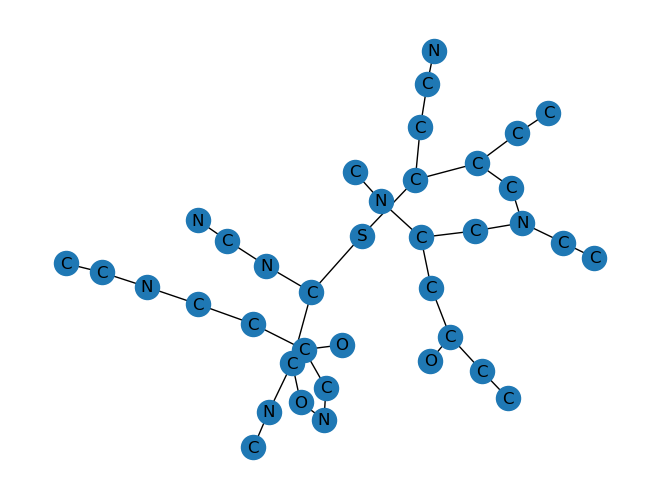

In [8]:
def format(n, d):
    if d['atom'].group_tag is None:
        return f'{d["atom"].element}'
    else:
        group_idx, inner_idx = d['atom'].group_tag
        group_name = molG.groups[group_idx].name

        inner_element = d['atom'].element
        return f'{group_name}_{inner_element}'
    
g = torch_geometric.utils.to_networkx(py_graph, to_undirected=True)
labels = {n: env.atom_symbols[torch.where(node==1)[0].item()] for n, node in enumerate(py_graph.x)}
nx.draw(g, labels=labels, with_labels=True)

In [9]:
env.atom_symbols

['F', 'Cl', 'N', 'C', 'O', 'Br', 'B', 'S', 'P']